In [1]:
from pathlib import Path
import os
import time
from itertools import product

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import AdamW

from src.model_dino.tf_data import get_tf_data, RandomStandardization
from src.models.models import UnetLight, UnetLightDecorrelated
from src.data.utils import get_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
h5_file = h5py.File("../data/processed/hdf5_2d/data_selected_slices.hdf5", "r")
clinical_df = pd.read_csv(
    "../data/clinical_info_with_lung_info.csv").set_index("patient_id")

In [3]:
ids_train, ids_val, ids_test = get_split(0)

In [4]:
BATCH_SIZE = 4
EPOCHS= 100
STEPS_PER_EPOCH = int(510 // BATCH_SIZE) # 5093 slices
STEPS_PER_EPOCH = 200

In [5]:
ds = get_tf_data(h5_file,
                 clinical_df,
                 patient_list=ids_train,
                 local_inpainting=False,
                 n_channels=2,
                 painting_method="random").repeat().batch(BATCH_SIZE).take(
                     STEPS_PER_EPOCH)


In [6]:
n_sclices = 0
for p_id in ids_train:
    n_sclices += h5_file[p_id]["image"][()].shape[2]
print(f"n_sclices in train {n_sclices}")

n_sclices in train 2316


In [7]:
for images in ds.take(1).as_numpy_iterator():
    pass

In [8]:
images[0].shape

(4, 256, 256, 2)

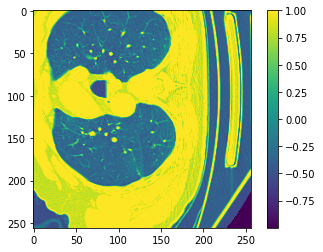

In [12]:
plt.imshow(images[1][1,:, :, 0])
plt.colorbar()

In [ ]:
model_t = UnetLightDecorrelated(output_channels=100, last_activation="linear")
model_s = UnetLightDecorrelated(output_channels=100, last_activation="linear")

In [ ]:
# model_s.load_weights("/home/valentin/python_wkspce/plc_segmentation/models/dino/model_s2/final")
# model_t.load_weights("/home/valentin/python_wkspce/plc_segmentation/models/dino/model_t2/final")

In [ ]:
plt.imshow(model_s(images[2])[0, :, :, 0])


In [ ]:
plt.imshow(model_t(images[2])[0, :, :, 0])

In [ ]:
for k in range(len(model_t.weights)):
    model_t.weights[k].assign(model_s.weights[k])


In [ ]:
plt.imshow(tf.nn.softmax(model_t(images[2]) / 0.04, axis=-1)[0, :, :, 2])
plt.colorbar()

In [ ]:
# Instantiate an optimizer to train the model.
# Instantiate a loss function.
tau_s = 0.1
tau_t = 0.04
m = 0.9
momentum_teacher = 0.996
weight_decay = 0.04
weight_decay_end = 0.4
lr = 1e-3
min_lr = 1e-6
# optimizer = AdamW(learning_rate=lr, weight_decay=weight_decay)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)


In [ ]:
def cosine_scheduler(base_value,
                     final_value,
                     epochs,
                     niter_per_ep,
                     warmup_epochs=0,
                     start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value,
                                      warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (
        1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule

In [ ]:
momentum_schedule = cosine_scheduler(momentum_teacher, 1, EPOCHS,
                                     STEPS_PER_EPOCH).astype(np.float32)


In [ ]:
wd_schedule = cosine_scheduler(
    weight_decay,
    weight_decay_end,
    EPOCHS,
    STEPS_PER_EPOCH,
)


In [ ]:
lr_schedule = cosine_scheduler(
    lr,  # linear scaling rule
    min_lr,
    EPOCHS,
    STEPS_PER_EPOCH,
    warmup_epochs=10,
)
lr_schedule = np.ones((EPOCHS * STEPS_PER_EPOCH)) * 1e-3


In [ ]:
plt.plot(momentum_schedule)

In [ ]:
@tf.function
def correlation_loss(y_pred):
    channels = tf.shape(y_pred)[-1]
    y = tf.reshape(y_pred, [-1, channels])
    y -= tf.reduce_mean(y, axis=0)
    corr_mat = tf.matmul(tf.transpose(y), y) / y.shape[0]
    return 1 - tf.linalg.det(corr_mat)


In [ ]:
y_pred = model_s(images[3])
channels = tf.shape(y_pred)[-1]
y = tf.reshape(y_pred, [-1, channels])
y -= tf.reduce_mean(y, axis=0)
corr_mat = tf.matmul(tf.transpose(y), y) / y.shape[0]


In [ ]:
np.linalg.det(corr_mat.numpy())

In [ ]:
correlation_loss(model_s(images[0]))

In [ ]:
images[0].shape

In [ ]:
@tf.function
def dino_loss(y_s, y_t, center=0):
    s = tf.nn.log_softmax(y_s / tau_s, axis=-1)
    t = tf.stop_gradient(tf.nn.softmax((y_t - center) / tau_t, axis=-1))
    return -tf.reduce_mean(tf.reduce_sum(t * s, axis=-1))


In [ ]:
@tf.function
def entropy(y_pred, tau):
    y_pred = tf.nn.softmax(y_pred / tau, axis=-1)
    log_y_pred = tf.nn.log_softmax(y_pred / tau, axis=-1)
    return -tf.reduce_mean(tf.reduce_sum(y_pred * log_y_pred, axis=-1))


In [ ]:
@tf.function
def train_step(images, momentum_teacher, optimizer=None, center=0):
    global_x = images[:2]

    y_t = list()
    for x in global_x:
        y_t.append(model_t(x, training=True))  # Forward pass

    if center is None:
        center = tf.reduce_mean(tf.concat(y_t, axis=0), axis=(0, 1, 2))
    with tf.GradientTape() as tape:
        y_s = list()
        for x in images:
            y_s.append(model_s(x, training=True))  # Forward pass
        n_loss = 0
        loss = 0
        for s_ind, t_ind in product(range(len(y_s)), range(len(y_t))):
            if s_ind == t_ind:
                continue
            loss += dino_loss(y_s[s_ind], y_t[t_ind], center=center)
            n_loss += 1
        loss = loss / float(n_loss)

    # Compute gradients
    gradients = tape.gradient(loss, model_s.trainable_variables)
    gradients = [tf.clip_by_norm(g, 1) for g in gradients]

    # Update weights
    optimizer.apply_gradients(zip(gradients, model_s.trainable_variables))

    for i, w in enumerate(model_t.weights):
        model_t.weights[i].assign(momentum_teacher * w +
                                  (1 - momentum_teacher) * model_s.weights[i])

    center = m * center + (1 - m) * tf.reduce_mean(tf.concat(y_t, axis=0),
                                                   axis=(0, 1, 2))
    return loss, center


In [ ]:
center = None
total_step = 0

In [ ]:
for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch, ))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, im in enumerate(ds):
        optimizer.lr = lr_schedule[step]
        # optimizer.weight_decay = wd_schedule[step]
        loss, center = train_step(im,
                                  momentum_schedule[total_step],
                                  optimizer=optimizer,
                                  center=center)

        # Log every 200 batches.
        if step % 10 == 0:
            print(f"Training loss dino: {loss} at step: {step}")
            print(f"entropy on batch: {entropy(model_t(im[0]),tau=tau_t)}")
            print("Seen so far: %d samples" % ((step + 1) * BATCH_SIZE))
            # print(f"center evolution {center[:10]}")

        total_step += 1

    print("Time taken: %.2fs" % (time.time() - start_time))


In [ ]:
pred = tf.nn.softmax(model_s(images[3])/tau_s , axis=-1).numpy()
# pred = model_s(images[3]).numpy()

In [ ]:
pred.shape

In [ ]:
np.min(pred)

In [ ]:
def power(y_pred):
    return np.sqrt(np.mean(y_pred**2, axis=(0, 1)))


In [ ]:

np.where(power(pred[0,...])>0.05)

In [ ]:
plt.plot(power(pred[0,...]))

In [ ]:
plt.imshow(pred[0,:,:,37])
plt.colorbar()
plt.savefig("test.png", dpi=600)

In [ ]:
plt.imshow(images[3][0,:,:,0])
# plt.imshow(images[0].numpy()[0,:,:,0])

In [ ]:
plt.imshow(images[3].numpy()[0,:,:,0])

In [ ]:
def get_cropped_image(image, mask, output_shape_image=(256, 256)):
    positions = np.where(mask != 0)
    s = int((np.max(positions[2]) + np.min(positions[2])) / 2)
    bb_lung = get_bb_mask_voxel(mask[..., 2] + mask[..., 3])
    center = ((bb_lung[:3] + bb_lung[3:]) // 2)[:2]
    r = [output_shape_image[i] // 2 for i in range(2)]
    mask = mask[center[0] - r[0]:center[0] + r[0],
                center[1] - r[1]:center[1] + r[1], s, 0]

    image = image[center[0] - r[0]:center[0] + r[0],
                  center[1] - r[1]:center[1] + r[1], s, :]

    return image, mask


def get_bb_mask_voxel(mask):
    positions = np.where(mask != 0)
    x_min = np.min(positions[0])
    y_min = np.min(positions[1])
    z_min = np.min(positions[2])
    x_max = np.max(positions[0])
    y_max = np.max(positions[1])
    z_max = np.max(positions[2])
    return np.array([x_min, y_min, z_min, x_max, y_max, z_max])


In [ ]:
def get_images(file, ids, output_shape_image=(256, 256), standardizer=None):
    images = list()
    masks = list()
    for i in ids:
        image = file[i]["image"][()]
        mask = file[i]["mask"][()]
        im, m = get_cropped_image(
            image,
            mask,
            output_shape_image=output_shape_image,
        )
        if standardizer:
            im = standardizer(im)
        images.append(im)
        masks.append(m)
    return np.stack(images, axis=0), np.stack(masks, axis=0)


In [ ]:
standardizer = RandomStandardization(p=0)

In [ ]:
images_train, masks_train = get_images(h5_file,
                                       ids_train,
                                       standardizer=standardizer)
images_val, masks_val = get_images(h5_file, ids_val, standardizer=standardizer)
images_test, masks_test = get_images(h5_file,
                                     ids_test,
                                     standardizer=standardizer)


In [ ]:
plt.imshow(masks_train[0,:,:])


In [ ]:
plt.imshow(images_train[0,:,:,0])
plt.colorbar()

In [ ]:
pred = tf.nn.softmax(model_s(images_train[:1,...])/tau_s).numpy()

In [ ]:
plt.plot(power(pred[0,...]))

In [ ]:
plt.imshow(pred[0,:,:,5])

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(np.reshape(images_train, [-1, 2]))

In [ ]:
pred_test = np.reshape(kmeans.predict(np.reshape(images_test, [-1, 2])), [-1,256,256,1])

In [ ]:
pred_test.shape

In [ ]:
plt.imshow(pred_test[19,:,:,0])

In [ ]:
preds_train = tf.nn.softmax(model_s(images_train) / tau_s).numpy()


In [ ]:
kmeans_dino = KMeans(n_clusters=10, random_state=0).fit(np.reshape(preds_train, [-1, 10]))

In [ ]:
pred_dino_test = np.reshape(
    kmeans_dino.predict(
        np.reshape(
            tf.nn.softmax(model_s(images_test) / tau_s).numpy(), [-1, 10])),
    [-1, 256, 256, 1])


In [ ]:
plt.imshow(pred_dino_test[0,:,:,0])

In [ ]:
plt.imshow(images_test[0,:,:,0])

In [ ]:
plt.imshow(masks_test[11,:,:])